In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from rulefit import RuleFit
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from price_prediction_helper import cross_val_scores
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,mean_squared_error,r2_score
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
data = pd.read_csv('price_prediction_data_montreal_700_pca.csv',low_memory=False)
data.shape

(20882, 36)

In [3]:
X = np.array(data.drop(columns=['price']))
y = data.price

results = pd.DataFrame() 


# Linear Regression

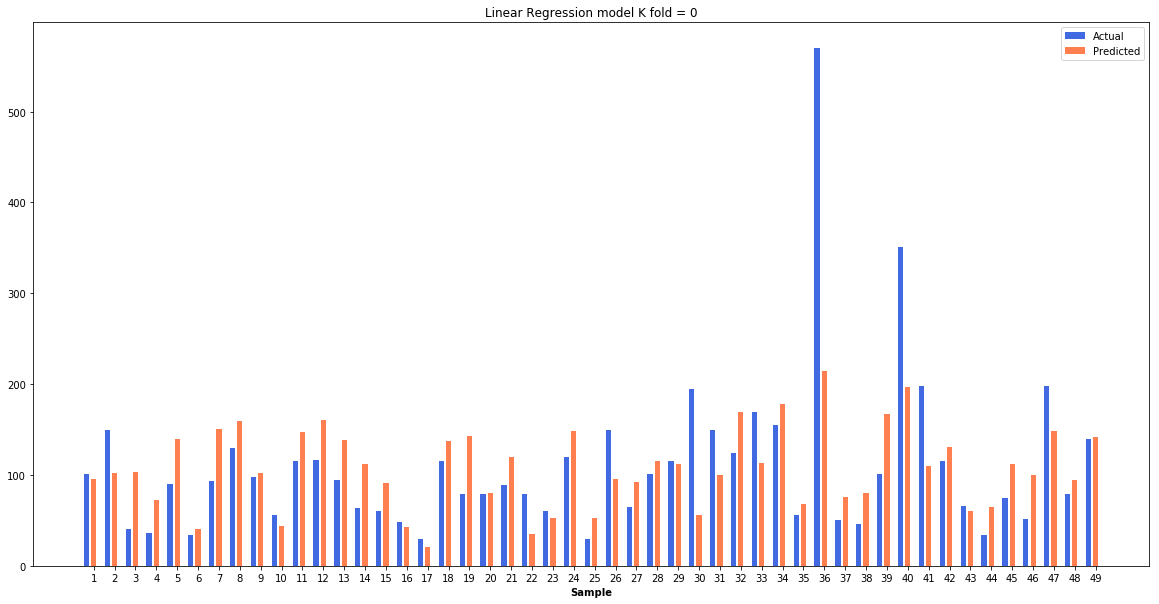

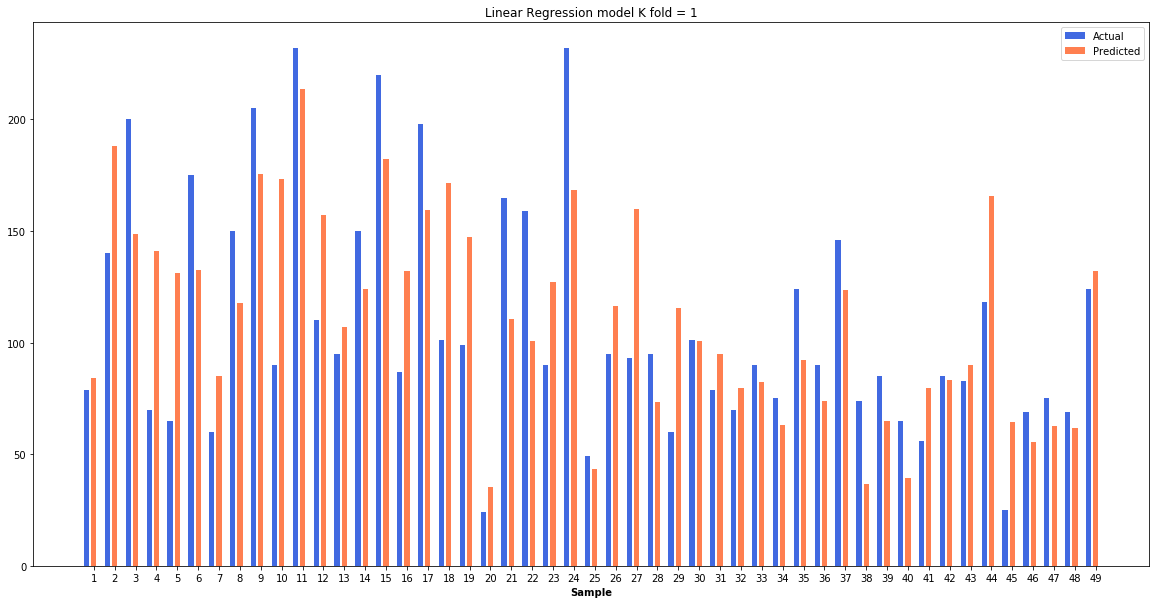

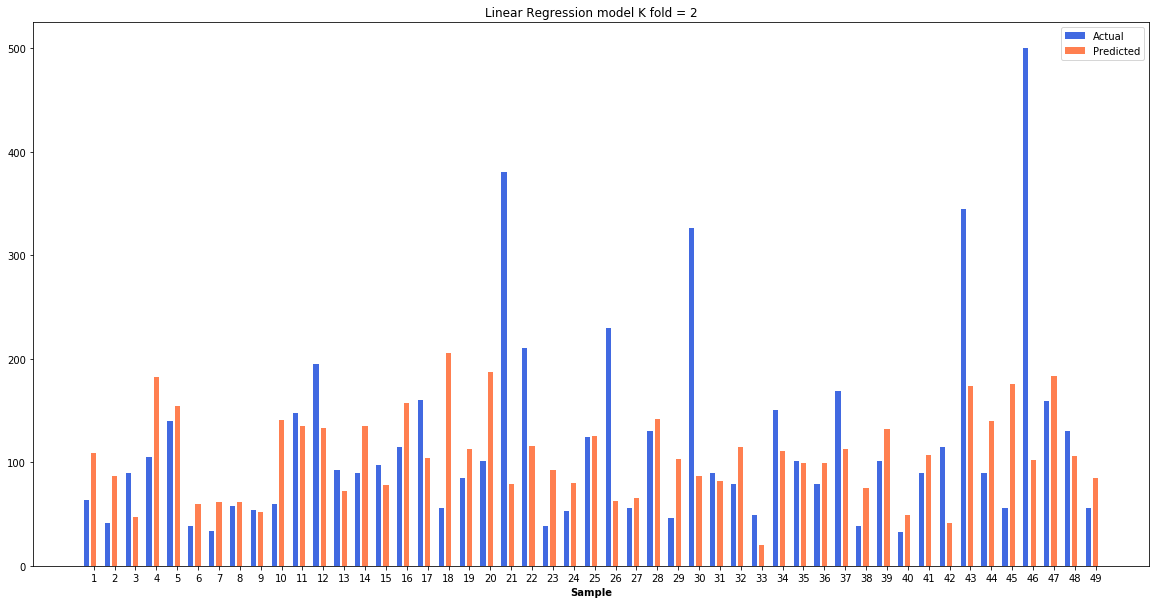

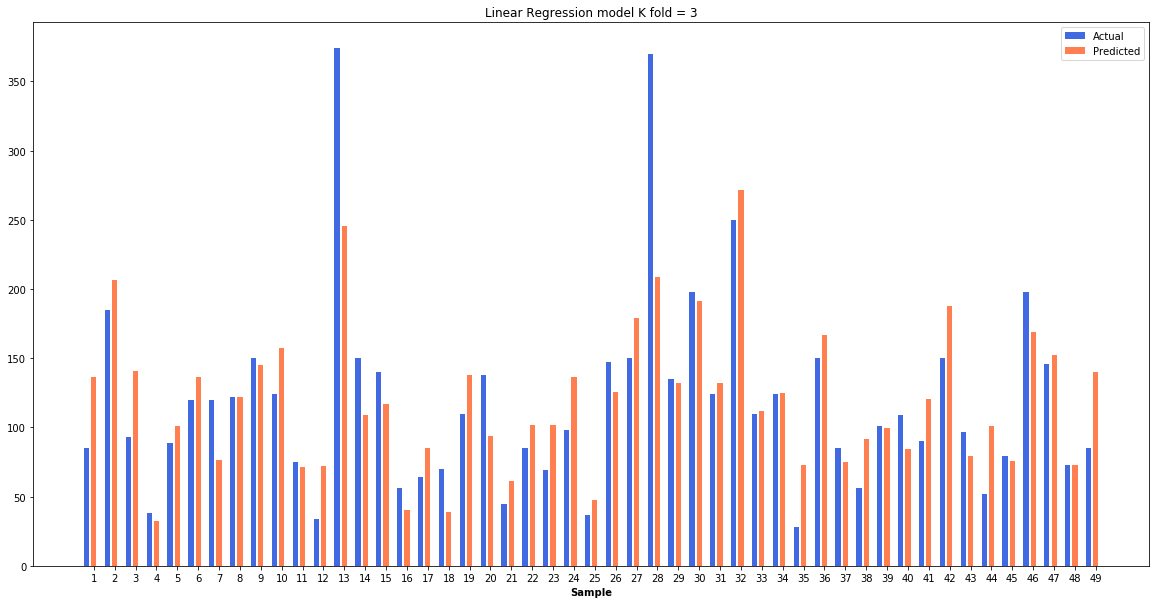

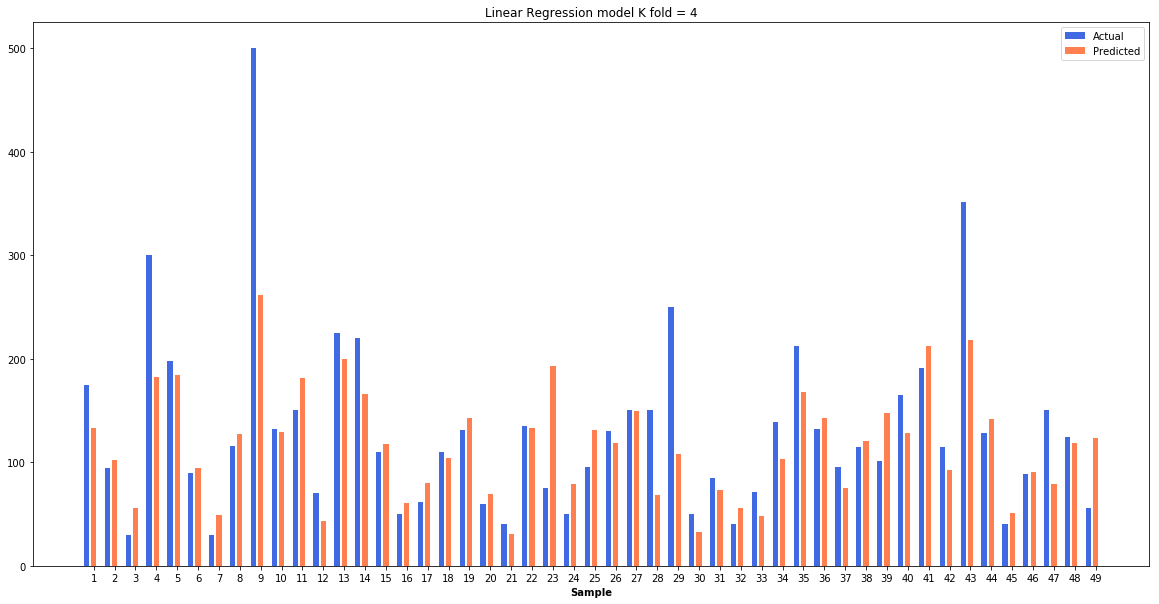

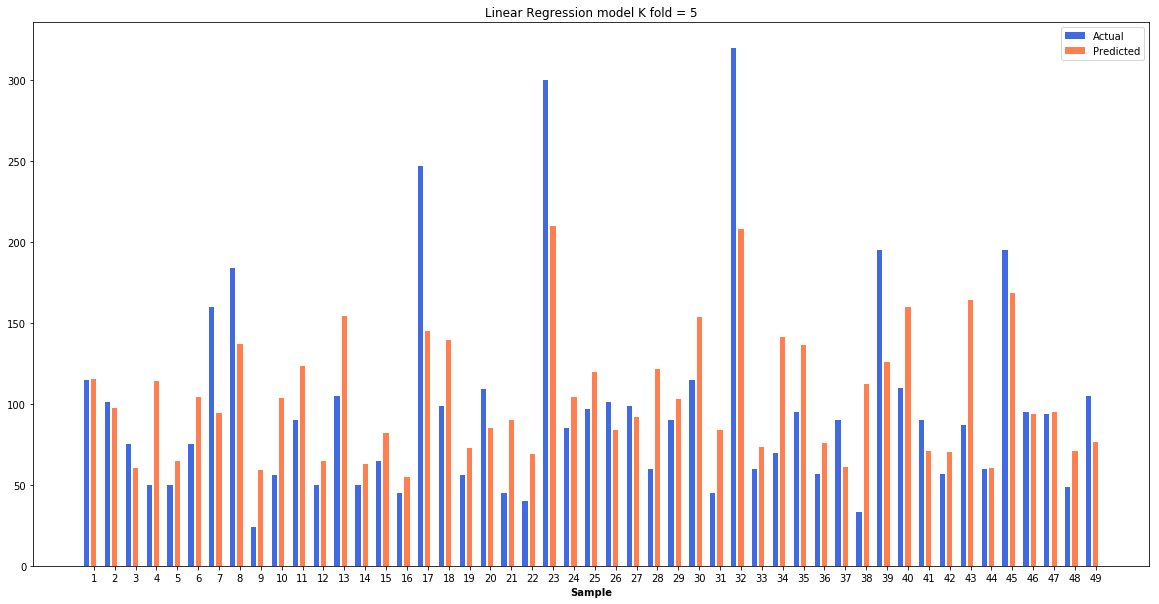

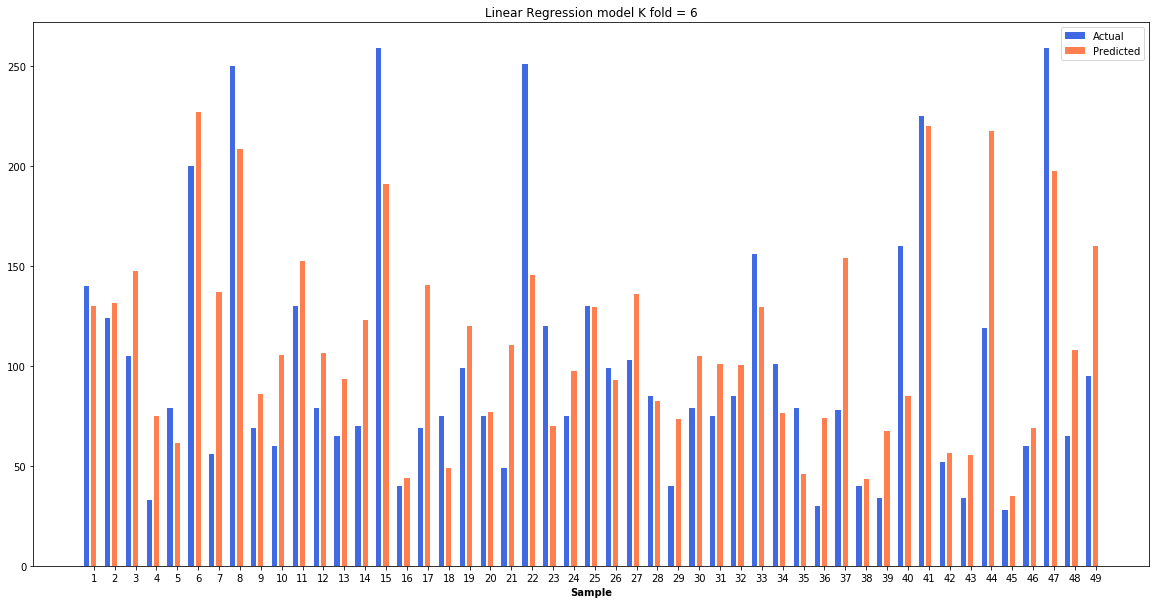

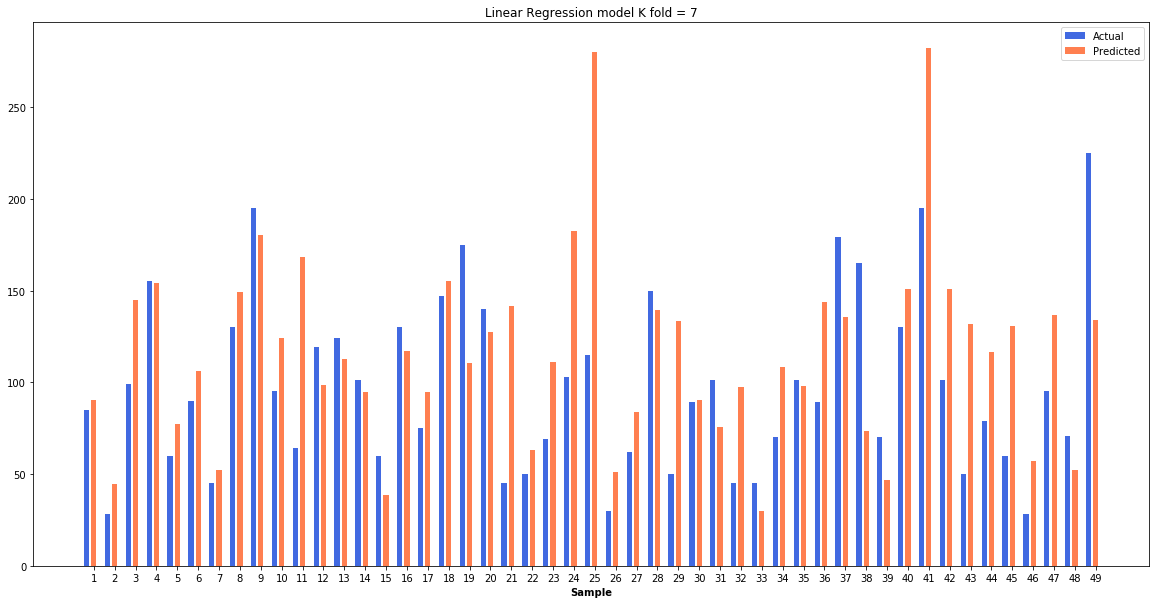

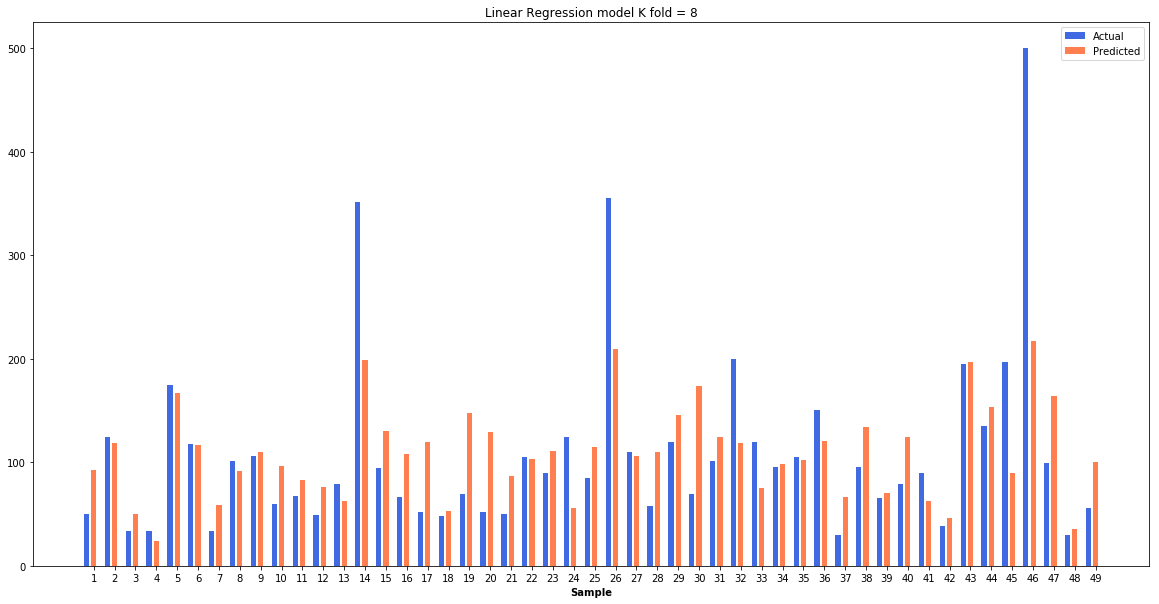

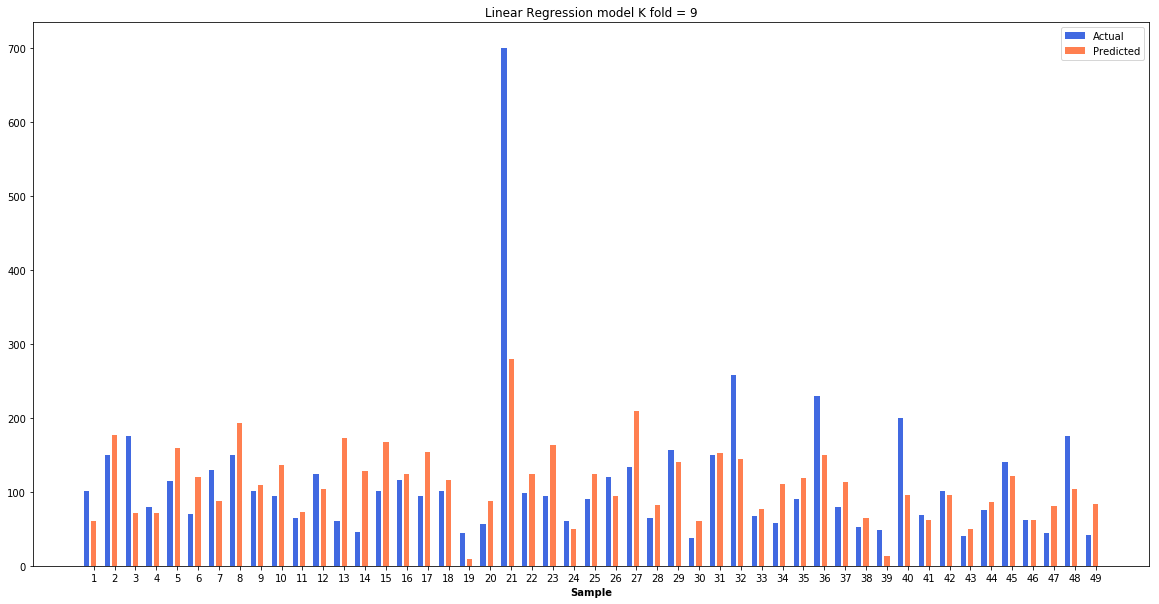

Linear Regression RMSE : 65.33 (+/- 2.65)
Linear Regression R2 Score: 0.41 (+/- 0.02)


In [4]:
clf = LinearRegression()
_,results['LinearRegression'],_,_=cross_val_scores('Linear Regression',clf,X,y,plot=True)

# Support Vector Regressor

In [5]:
from sklearn.svm import SVR
clf = SVR(kernel = 'rbf', C=10, degree=1, gamma=0.1)
_,results['SVR'],_,_=cross_val_scores('Support Vector Machines', clf, X, y)

Support Vector Machines RMSE : 67.47 (+/- 3.06)
Support Vector Machines R2 Score: 0.37 (+/- 0.02)


# Decision Trees

In [6]:
clf = DecisionTreeRegressor(min_samples_split=5,max_depth=6,random_state=0)
_,results['DecisionTrees'],_,_=cross_val_scores('DT',clf,X, y,plot=False)

DT RMSE : 68.99 (+/- 2.54)
DT R2 Score: 0.34 (+/- 0.04)


# K Nearest Neighbours

In [7]:
K = 10
clf = KNeighborsRegressor(n_neighbors = K,n_jobs=-1)
_,results['KNearestNeighbours'],_,_ = cross_val_scores('KNN-'+str(K),clf,X,y,cv=10)

KNN-10 RMSE : 73.03 (+/- 2.41)
KNN-10 R2 Score: 0.26 (+/- 0.03)


# Rule

In [8]:
scoring = {'R2': make_scorer(r2_score), 'RMSE': make_scorer(mean_squared_error)}

rf = RuleFit(memory_par=0.01, tree_size=4, tree_generator=None, max_rules=100,rfmode='regress',random_state=1) 
result_cross_val = pd.DataFrame(cross_validate(rf.fit(X, y), X, y, cv=10, scoring=scoring))

In [9]:
results['RuleFit'] = result_cross_val['test_R2']

In [10]:
mean_rmse = np.sqrt(np.array(result_cross_val['test_RMSE'])).mean()
std_rmse =  np.sqrt(np.array(result_cross_val['test_RMSE'])).std()
print("%s RMSE : %0.2f (+/- %0.2f)" % ('RuleFit', mean_rmse, std_rmse))

mean_r2 = np.array(result_cross_val['test_R2']).mean()
std_r2 =  np.array(result_cross_val['test_R2']).std()
print("%s R2 Score: %0.2f (+/- %0.2f)" % ('RuleFit', mean_r2, std_r2))

RuleFit RMSE : 65.54 (+/- 6.80)
RuleFit R2 Score: 0.39 (+/- 0.06)


In [11]:
rules = pd.DataFrame(rf.get_rules())
rules = rules[rules.coef != 0].sort_values(by="support")
num_rules_rule=len(rules[rules.type=='rule'])
num_rules_linear=len(rules[rules.type=='linear'])
rules.head()

,rule,type,coef,support,importance
67,feature_17 <= 0.12409398704767227 & feature_0 ...,rule,17.625743,0.002068,0.800755
49,feature_20 > 0.21528705209493637 & feature_22 ...,rule,27.782326,0.007239,2.355194
116,feature_17 <= 0.10096078738570213 & feature_22...,rule,16.378035,0.008273,1.483507
117,feature_20 > 0.22552256286144257 & feature_31 ...,rule,0.196834,0.011375,0.020874
48,feature_17 <= 0.05215654335916042 & feature_1 ...,rule,18.614020,0.018614,2.515840


# Random Forest

In [12]:
clf = RandomForestRegressor(max_depth=None,n_estimators=300,min_samples_split=5,n_jobs=-1)
_,results['RandomForest'],_,_ = cross_val_scores('RF',clf,X,y)

RF RMSE : 62.33 (+/- 2.47)
RF R2 Score: 0.46 (+/- 0.02)


# Light GBM

In [13]:

clf = lgb.LGBMRegressor(learning_rate=0.04,max_depth=None,col_by_sample=1,n_estimators=500)
_,results['LightGBM'],_,_ = cross_val_scores('LGBM',clf,X,y)

LGBM RMSE : 60.36 (+/- 2.49)
LGBM R2 Score: 0.50 (+/- 0.02)


# XGBoost

In [14]:
model = XGBRegressor(learning_rate=0.02,max_depth=8,n_estimators=300,objective ='reg:squarederror')
_,results['XGBoost'],_,_ = cross_val_scores('XGBoost', model, X, y)

XGBoost RMSE : 61.42 (+/- 2.62)
XGBoost R2 Score: 0.48 (+/- 0.03)


# Generating Results

In [15]:
results.to_csv('price_prediction_results.csv',index=None,header=True)